In [24]:
import pandas as pd
import matplotlib.pyplot as plt


In [25]:
#only local
import os

BASE_DIR = os.path.abspath(os.path.join(os.path.dirname("__file__"), "..",".."))

In [46]:
EXTERNAL_DATA_PATH = os.path.join(BASE_DIR, "data", "external", "Temperature_chicago.csv")
RAW_SAVE_PATH = os.path.join(BASE_DIR, "data", "raw", "energy_consumption_raw.csv")
ENERGY_RAW_PATH = os.path.join(BASE_DIR, "data", "raw", "COMED_hourly.csv")

In [27]:
# Datei einlesen
df_temp_raw = pd.read_csv(EXTERNAL_DATA_PATH)

In [44]:
df_temp_raw.head(10)

,STATION,DATE,SOURCE,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,TMP,TMP_CLEAN,temperature_c,datetime,datetime_rounded
0,72534014819,2011-01-01T00:51:00,7,FM-15,KMDW,V020,"+0128,5",128.5,12.85,2011-01-01 00:51:00,2011-01-01 00:00:00
1,72534014819,2011-01-01T01:49:00,6,FM-16,KMDW,V020,"+0130,5",130.5,13.05,2011-01-01 01:49:00,2011-01-01 01:00:00
2,72534014819,2011-01-01T01:51:00,7,FM-15,KMDW,V020,"+0128,5",128.5,12.85,2011-01-01 01:51:00,2011-01-01 01:00:00
3,72534014819,2011-01-01T02:04:00,7,FM-16,KMDW,V020,"+0130,5",130.5,13.05,2011-01-01 02:04:00,2011-01-01 02:00:00
4,72534014819,2011-01-01T02:17:00,7,FM-16,KMDW,V020,"+0130,5",130.5,13.05,2011-01-01 02:17:00,2011-01-01 02:00:00
5,72534014819,2011-01-01T02:51:00,7,FM-15,KMDW,V020,"+0122,5",122.5,12.25,2011-01-01 02:51:00,2011-01-01 02:00:00
6,72534014819,2011-01-01T03:00:00,4,FM-12,KMDW,V020,"+0122,1",122.1,12.21,2011-01-01 03:00:00,2011-01-01 03:00:00
7,72534014819,2011-01-01T03:51:00,7,FM-15,KMDW,V020,"+0128,5",128.5,12.85,2011-01-01 03:51:00,2011-01-01 03:00:00
8,72534014819,2011-01-01T04:51:00,7,FM-15,KMDW,V020,"+0133,5",133.5,13.35,2011-01-01 04:51:00,2011-01-01 04:00:00
9,72534014819,2011-01-01T05:51:00,7,FM-15,KMDW,V020,"+0094,5",94.5,9.45,2011-01-01 05:51:00,2011-01-01 05:00:00


In [29]:
#temp /10 needed

df_temp_raw["TMP_CLEAN"] = (
    df_temp_raw["TMP"]
    .str.replace(",", ".")  # deutsches Komma durch Punkt ersetzen
    .str.extract(r"([-+]?\d+\.?\d*)")[0]  # nur Zahl extrahieren
    .astype(float)
)

# Entferne Ausreißer
df_temp_raw = df_temp_raw[df_temp_raw["TMP_CLEAN"] < 900].copy()

# Umrechnen in Grad Celsius (weil Zehntelgrad!)
df_temp_raw["temperature_c"] = df_temp_raw["TMP_CLEAN"] / 10


In [30]:
df_temp_raw.head()

,STATION,DATE,SOURCE,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,TMP,TMP_CLEAN,temperature_c
0,72534014819,2011-01-01T00:51:00,7,FM-15,KMDW,V020,"+0128,5",128.5,12.85
1,72534014819,2011-01-01T01:49:00,6,FM-16,KMDW,V020,"+0130,5",130.5,13.05
2,72534014819,2011-01-01T01:51:00,7,FM-15,KMDW,V020,"+0128,5",128.5,12.85
3,72534014819,2011-01-01T02:04:00,7,FM-16,KMDW,V020,"+0130,5",130.5,13.05
4,72534014819,2011-01-01T02:17:00,7,FM-16,KMDW,V020,"+0130,5",130.5,13.05


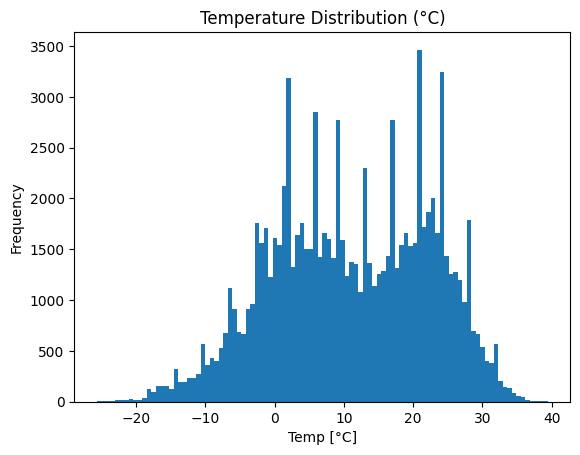

In [31]:
df_temp_raw["temperature_c"].hist(bins=100)
plt.title("Temperature Distribution (°C)")
plt.xlabel("Temp [°C]")
plt.ylabel("Frequency")
plt.grid()
plt.show()


In [32]:
df_temp_raw["temperature_c"].describe()

count    96475.000000
mean        11.112878
std         11.403130
min        -25.650000
25%          2.210000
50%         11.150000
75%         21.050000
max         39.450000
Name: temperature_c, dtype: float64

In [33]:
#correct datetime to full hour, if more temp values for it, use mean
# Zeitstempel parsen
df_temp_raw["datetime"] = pd.to_datetime(df_temp_raw["DATE"])

# Auf Stunde runden
df_temp_raw["datetime_rounded"] = df_temp_raw["datetime"].dt.floor("h")

# Nach Stunde mitteln (für mehrere Einträge pro Stunde)
df_temp_hourly = df_temp_raw.groupby("datetime_rounded")["temperature_c"].mean().round(2).reset_index()

# Optional: Umbenennen
df_temp_hourly = df_temp_hourly.rename(columns={"datetime_rounded": "datetime"})

In [34]:
df_temp_hourly.head()

,datetime,temperature_c
0,2011-01-01 00:00:00,12.85
1,2011-01-01 01:00:00,12.95
2,2011-01-01 02:00:00,12.78
3,2011-01-01 03:00:00,12.53
4,2011-01-01 04:00:00,13.35


In [35]:
#merge with chicago data
df_energy = pd.read_csv(ENERGY_RAW_PATH, sep=";")

In [36]:
df_energy.head()

,Datetime,COMED_MW
0,31.12.2011 01:00,99700
1,31.12.2011 02:00,94280
2,31.12.2011 03:00,90590
3,31.12.2011 04:00,88170
4,31.12.2011 05:00,87430


In [37]:
df_energy = df_energy.rename(columns={
    "Datetime": "datetime",
    "COMED_MW": "consumption_MW"
})


In [39]:
df_energy["datetime"] = pd.to_datetime(df_energy["datetime"], format="%d.%m.%Y %H:%M")

# Jetzt sortieren!
df_energy = df_energy.sort_values("datetime").reset_index(drop=True)


In [40]:
df_energy.head(100)


,datetime,consumption_MW
0,2011-01-01 01:00:00,96310
1,2011-01-01 02:00:00,92730
2,2011-01-01 03:00:00,90110
3,2011-01-01 04:00:00,87410
4,2011-01-01 05:00:00,86940
...,...,...
95,2011-01-05 00:00:00,126000
96,2011-01-05 01:00:00,118290
97,2011-01-05 02:00:00,113240
98,2011-01-05 03:00:00,110620


In [41]:
df_merged = pd.merge(
    df_energy,
    df_temp_hourly,
    how="left",
    left_on="datetime",     # oder "date", je nach Spaltenname
    right_on="datetime"
)


In [43]:
df_merged.head(-1)

,datetime,consumption_MW,temperature_c
0,2011-01-01 01:00:00,96310,12.95
1,2011-01-01 02:00:00,92730,12.78
2,2011-01-01 03:00:00,90110,12.53
3,2011-01-01 04:00:00,87410,13.35
4,2011-01-01 05:00:00,86940,8.75
...,...,...,...
66491,2018-08-02 19:00:00,168970,30.05
66492,2018-08-02 20:00:00,164370,29.45
66493,2018-08-02 21:00:00,155900,29.18
66494,2018-08-02 22:00:00,150860,29.45


In [45]:
# DataFrame speichern als CSV
df_merged.to_csv(RAW_SAVE_PATH, index=False)
print(f"Datei gespeichert unter: {RAW_SAVE_PATH}")



Datei gespeichert unter: C:\Users\Anwender\Desktop\Projects\Energy_prediction\data\raw\energy_consumption_raw.csv
